<a href="https://colab.research.google.com/github/amarjit420/Vector_Demos/blob/main/Astra_Vector_Hybrid_Search_Cheese_Demo_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Astra Vector Embedding Search with Text Analyser

Jupyter notebook for image search powered by [Astra Vector Search](https://docs.datastax.com/en/astra-serverless/docs/vector-search/overview.html) and Hugging Face Sentence Transfromer [obrizum/all-MiniLM-L6-v2].


## Transformer Model
This is a sentence-transformers model: It maps sentences & paragraphs to a 384 dimensional dense vector space and can be used for tasks like clustering or semantic search.

The model is intented to be used as a sentence and short paragraph encoder. Given an input text, it ouptuts a vector which captures the semantic information. The sentence vector may be used for information retrieval, clustering or sentence similarity tasks.


## Astra Vector Search
Astra vector search enables developers to search a database by context or meaning rather than keywords or literal values. This is done by using “embeddings”. Embeddings are a type of representation used in machine learning where high-dimensional or complex data is mapped onto vectors in a lower-dimensional space. These vectors capture the semantic properties of the input data, meaning that similar data points have similar embeddings.

## Astra Hybrid Queries
Hybrid queries leverage VSS in conjunction with predicates (aka "filters") on other columns. Using partition keys, clustering columns, and indexed SAI columns, you can write expressive hybrid queries that order the column filtered search results by their similarity to the semantic search vector.
Think about trying to find a product on your favorite retailer's website. VSS can use what we type into the search box to find related products, but what if we only want it in color:blue or size:medium? To get specific about what we're looking for, semantic search needs some help from more conventional query terms.


## Demo Summary
The demo showcases the transformer model, which generates embeddings for images. These embeddings, along with metadata, are stored in Astra DB. Specifically, the embeddings are stored in a column of type Vector, in addition an analyzer SAI index is also created on the description column.

The goal of the demo is to utilize Astra Hybrid Search to search for different types of cheese based on the semantics of the vector search and the SAI index.


## Sample Data

The sample dataset is in the following JSON format:

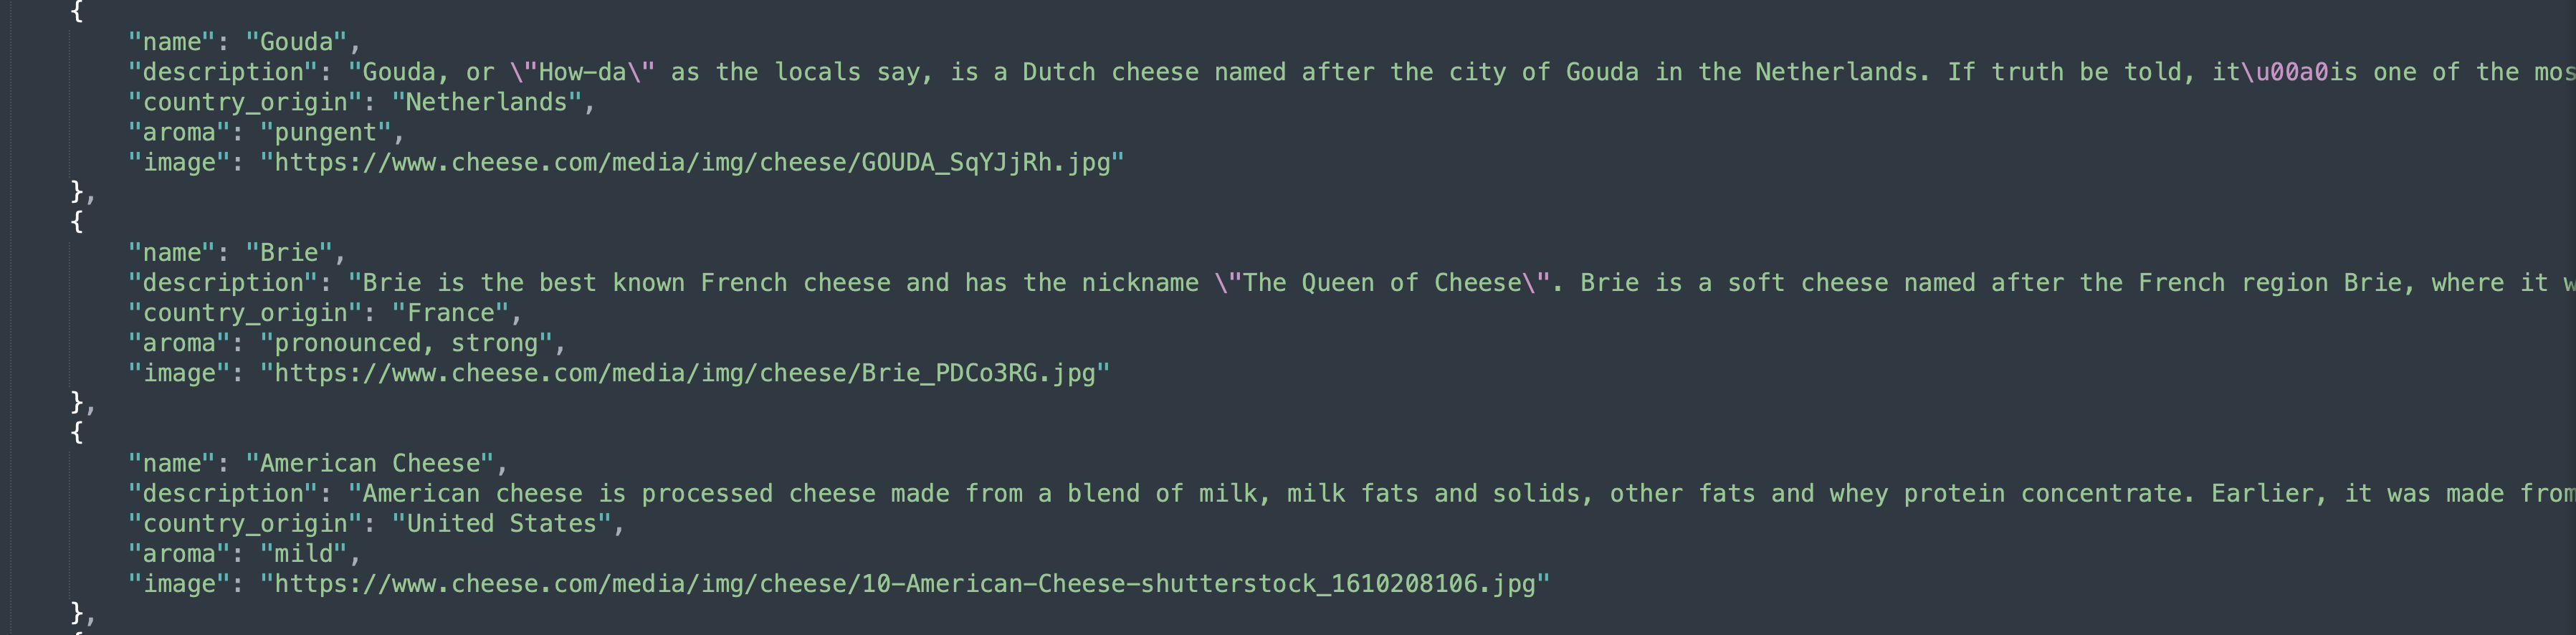

# Getting Started with this notebook
   
Create a serverless vector database with Astra Vector Search and set up its schema.
(https://astra.datastax.com)  

In [ ]:
!pip3 install cassandra-driver matplotlib sentence-transformers pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 65.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 13.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 106.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 102.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 125.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 104.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 41.8 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=08e543031d5c0894724dc880d62dc0e3b92c64590b381abe054d00296b5ab3af
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sent

# Imports

In [ ]:
import os

from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider

from PIL import Image
from sentence_transformers import SentenceTransformer
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from getpass import getpass

# Astra Variables

Vector database credentials and secure connect bundle

In [ ]:
# Input your Astra DB token string, the one starting with "AstraCS:..."
ASTRA_DB_TOKEN_BASED_PASSWORD = getpass('Your Astra DB Token ("AstraCS:..."): ')

Your Astra DB Token ("AstraCS:..."): ··········


In [ ]:
# Input your database keyspace name:
ASTRA_DB_KEYSPACE = input('Your Astra DB Keyspace name (e.g. imagevecs): ')

Your Astra DB Keyspace name (e.g. imagevecs): ks


In [ ]:
# Input your database table name:
ASTRA_DB_TABLE = input('Your Astra DB Table name (e.g. cheese): ')

Your Astra DB Table name (e.g. cheese): cheese


In [ ]:
# Upload your Secure Connect Bundle zipfile:
import os
from google.colab import files


print('Please upload your Secure Connect Bundle')
uploaded = files.upload()
if uploaded:
    astraBundleFileTitle = list(uploaded.keys())[0]
    scb_path = os.path.join(os.getcwd(), astraBundleFileTitle)
else:
    raise ValueError(
        'Cannot proceed without Secure Connect Bundle. Please re-run the cell.'
    )

Please upload your Secure Connect Bundle


Saving secure-connect-vss.zip to secure-connect-vss.zip


In [ ]:
SECURE_CONNECT_BUNDLE_PATH = scb_path
ASTRA_CLIENT_ID = 'token'
ASTRA_CLIENT_SECRET = ASTRA_DB_TOKEN_BASED_PASSWORD
KEYSPACE_NAME = ASTRA_DB_KEYSPACE
TABLE_NAME = ASTRA_DB_TABLE

# Connect to Astra DB

In [ ]:
cloud_config = {
   'secure_connect_bundle': SECURE_CONNECT_BUNDLE_PATH
}
auth_provider = PlainTextAuthProvider(ASTRA_CLIENT_ID, ASTRA_CLIENT_SECRET)
cluster = Cluster(cloud=cloud_config, auth_provider=auth_provider, protocol_version=4)
session = cluster.connect()

# Drop / Create Schema


The sample data is in the format

```
    {
        "name": "Brie",
        "description": "Brie is the best known French cheese and has the nickname ....",
        "country_origin": "France",
        "aroma": "pronounced, strong",
        "image": "https://www.cheese.com/media/img/cheese/Brie_PDCo3RG.jpg"
    },
```

The following table schema is used in the demo:

```
CREATE TABLE IF NOT EXISTS ks1.cheese (
   id int PRIMARY KEY,
   description TEXT,
   name TEXT,
   aroma TEXT,
   country_origin TEXT,
   image TEXT,
   item_vector VECTOR<FLOAT, 384>
  )
```

The following indexes are used in the demo:

```
CREATE CUSTOM INDEX ON {KEYSPACE_NAME}.{TABLE_NAME}(description)
USING 'StorageAttachedIndex'
WITH OPTIONS = { 'index_analyzer':
                   '{"tokenizer" :
                         {"name" : "standard"},
                          "filters" :
                             [{
                                "name" : "porterstem"
                              }]}
                '};
```

```
CREATE CUSTOM INDEX IF NOT EXISTS ON {KEYSPACE_NAME}.{TABLE_NAME}(item_vector) USING 'StorageAttachedIndex'
```

In [ ]:
print(f"Creating table {TABLE_NAME} in keyspace {KEYSPACE_NAME}")
session.execute(f"CREATE TABLE IF NOT EXISTS {KEYSPACE_NAME}.{TABLE_NAME} (id int PRIMARY KEY, description TEXT, name TEXT, aroma TEXT, country_origin TEXT, image TEXT, item_vector VECTOR<FLOAT, 384>)")

Creating table cheese in keyspace ks


## Vector index

In [ ]:
print(f"Creating index on the vector element on table {TABLE_NAME} ")
session.execute(f"CREATE CUSTOM INDEX IF NOT EXISTS ON {KEYSPACE_NAME}.{TABLE_NAME}(item_vector) USING 'StorageAttachedIndex'")

Creating index on the vector element on table cheese 


## Analyzer index

In [ ]:
print(f"Creating tokenizer index on the description element on table {TABLE_NAME} ")
session.execute(f"""CREATE CUSTOM INDEX IF NOT EXISTS ON {KEYSPACE_NAME}.{TABLE_NAME} (description) USING 'StorageAttachedIndex' WITH OPTIONS = {{'index_analyzer': '{{"tokenizer" : {{"name" : "standard"}},"filters" : [{{"name" : "porterstem"}},{{"name" : "lowercase",      "args": {{}}}}]}}'}};""")

Creating tokenizer index on the description element on table cheese 


In [ ]:
print(f"Creating index on the name")
session.execute(f"CREATE CUSTOM INDEX IF NOT EXISTS ON {KEYSPACE_NAME}.{TABLE_NAME} (name) USING 'StorageAttachedIndex'")
print(f"Creating index on the aroma")
session.execute(f"CREATE CUSTOM INDEX IF NOT EXISTS ON {KEYSPACE_NAME}.{TABLE_NAME} (aroma) USING 'StorageAttachedIndex'")
print(f"Creating index on the country_origin")
session.execute(f"CREATE CUSTOM INDEX IF NOT EXISTS ON {KEYSPACE_NAME}.{TABLE_NAME} (country_origin) USING 'StorageAttachedIndex'")

Creating index on the name
Creating index on the aroma
Creating index on the country_origin


## Drop the table

incase this demo is re-run

In [ ]:
print(f"Truncate table {TABLE_NAME} in keyspace {KEYSPACE_NAME}")
session.execute(f"TRUNCATE TABLE {KEYSPACE_NAME}.{TABLE_NAME}")

Truncate table cheese in keyspace ks



**Load the model**


In [ ]:
model = SentenceTransformer('obrizum/all-MiniLM-L6-v2')


In [ ]:
import json
import requests

def clean_description(text):
    # Remove carriage returns and newlines
    cleaned_text = text.replace('\n', ' ').replace('\r', ' ')
    # Remove commas and special characters
    cleaned_text = ''.join(char for char in cleaned_text if char.isalnum() or char.isspace())
    return cleaned_text[:250]  # Limit description to 250 characters after cleaning

# Function to extract image URLs from the description text
def extract_image_urls(description):
    words = description.split()
    image_urls = [word for word in words if word.startswith("https://") and word.endswith(".jpg")]
    return image_urls[0] if image_urls else 'Image URL not found'

image_data = []

# Use the raw GitHub URL to get the actual JSON content
response = requests.get('https://raw.githubusercontent.com/amarjit420/Vector_Demos/main/Data/cheese_data.json')
response.raise_for_status()  # This will raise an error if the request failed
cheese_data = response.json()

# Fix the indentation for the loop
for index, cheese_entry in enumerate(cheese_data, start=1):
    name = cheese_entry.get('name', 'Unknown')
    description = clean_description(cheese_entry.get('description', 'No description available'))
    country_origin = cheese_entry.get('country_origin', 'Unknown')
    aroma = cheese_entry.get('aroma', 'Unknown')
    image_url = extract_image_urls(cheese_entry.get('image', ''))

    # Place holder embedding
    embedding = '1111.2222'

    # Create the image_data structure
    image_data.append((index, name, description, aroma, country_origin, image_url, embedding))

# Pretty print the image_data
print(json.dumps(image_data, indent=4))



[
    [
        1,
        "Gouda",
        "Gouda or Howda as the locals say is a Dutch cheese named after the city of Gouda in the Netherlands If truth be told it\u00a0is one of the most popular cheeses in the world accounting for 50 to 60 of the worlds cheese consumption It is a semihard cheese c",
        "pungent",
        "Netherlands",
        "https://www.cheese.com/media/img/cheese/GOUDA_SqYJjRh.jpg",
        "1112.2222"
    ],
    [
        2,
        "Brie",
        "Brie is the best known French cheese and has the nickname The Queen of Cheese Brie is a soft cheese named after the French region Brie where it was originally created Several hundred years ago Brie was one of the tributes which had to be paid to the ",
        "pronounced, strong",
        "France",
        "https://www.cheese.com/media/img/cheese/Brie_PDCo3RG.jpg",
        "1112.2222"
    ],
    [
        3,
        "American Cheese",
        "American cheese is processed cheese made from a blend of milk milk f

## Insert data

Insert the sample JSON data with the vector embedding into Astra table


In [ ]:
for cheese_tuple in image_data:
    index = cheese_tuple[0]
    name = cheese_tuple[1]
    description = cheese_tuple[2]
    aroma = cheese_tuple[3]
    country = cheese_tuple[4]
    image_url = cheese_tuple[5]
    embeddings = model.encode(name).tolist()
    print("Vectorisation of ", model.encode(name))
    print("Embedding is: ", embeddings)

    session.execute(
        f"INSERT INTO {KEYSPACE_NAME}.{TABLE_NAME} (id, description, name, aroma, country_origin, image, item_vector) VALUES {index, description, name, aroma, country, image_url, embeddings}")

[0.030271485447883606, -0.010784965939819813, -0.05597636103630066, 0.006406696047633886, -0.08654125779867172, 0.021574849262833595, 0.08221589028835297, -0.0050795129500329494, -0.014047316275537014, -0.0551614835858345, 0.10006481409072876, -0.04404616728425026, -0.03205014020204544, 0.022445641458034515, 0.015694811940193176, -0.05096999183297157, 0.02407393604516983, -0.12951543927192688, 0.02154112607240677, -0.03000221587717533, -0.022358648478984833, 0.06121295690536499, -0.021191203966736794, -0.00537205720320344, -0.06006878986954689, 0.06359569728374481, 0.043764762580394745, -0.08200683444738388, -0.024741364642977715, -0.08576475083827972, 0.02387513406574726, 0.02790386602282524, -0.008350000716745853, -0.03436571732163429, -0.07832511514425278, -0.05330364406108856, -0.004582136403769255, -0.018887683749198914, -0.010424165055155754, 0.06536276638507843, -0.03505092114210129, -0.00028446444775909185, 0.006299057509750128, -0.023065514862537384, 0.01069797296077013, 0.006

## Perform a text based search on the description field

Test the **analyser indexer** with a text based search, you can change the text word to test different scenarios.

In [1]:
text_search = "soft"

for row in session.execute(
        f"SELECT id, name FROM {KEYSPACE_NAME}.{TABLE_NAME} where description : '{text_search}'   LIMIT 3"):
    print("\t" + str(row))



NameError: ignored

## Perform a vector based search on the embedded field

Test the **semantic vector** embedding with a cheese name in the dataset
i.e.

*   *Brie* for an exact match
*   *Edam* for a nearest neighbour match (Edam not in dataset)
*   *Smokey* / *United States* / *Blue* for a semantic search of that type of cheese


In [ ]:
import pandas as pd

query_string = "blue"

text_emb = model.encode(query_string)
print(f"model provided embeddings for the string: '. {text_emb.tolist()}")
embeddings_str = ", ".join(map(str, text_emb.tolist()))
query = f"SELECT id, name, aroma, image FROM {KEYSPACE_NAME}.{TABLE_NAME}  ORDER BY item_vector ANN OF [{embeddings_str}] LIMIT 3"
results = session.execute(query)
top_results = results._current_rows

df = pd.DataFrame(top_results, columns = [ 'ID', 'Name', 'aroma', 'country' ])
print(df)

## Hybrid search across vector embedding and text

Test the hybrid search of the semantic search with a text i.e.

* Vector search of *Blue* and text of *Sweet*
* Vector search of *United* States and text of *Creamy*
* Vector search of *Smooth* and text of *Mature*


In [ ]:
import pandas as pd

word_search = "sweet"
vector_string = "blue"

text_emb = model.encode(vector_string)
print(f"model provided embeddings for the string: '. {text_emb.tolist()}")
embeddings_str = ", ".join(map(str, text_emb.tolist()))
query = f"SELECT id, name, aroma, image FROM {KEYSPACE_NAME}.{TABLE_NAME} WHERE description : '{word_search}' ORDER BY item_vector ANN OF [{embeddings_str}] LIMIT 3"
results = session.execute(query)
top_results = results._current_rows

df = pd.DataFrame(top_results, columns = [ 'ID', 'Name', 'aroma', 'country' ])
print(df)

model provided embeddings for the string: '. [-0.06580827385187149, 0.02037643827497959, -0.05504946410655975, -0.0030115169938653708, 0.013432063162326813, 0.02449326403439045, 0.20061416923999786, -0.009837902151048183, 0.043827615678310394, -0.01033156830817461, -0.022953376173973083, -0.04207928106188774, 0.010557080619037151, -0.02419096603989601, -0.008913316763937473, 0.09726928174495697, 0.005452209617942572, -0.11750150471925735, -0.12189485132694244, -0.051043033599853516, -0.012222512625157833, 0.048834946006536484, -0.05009819194674492, 0.04671303182840347, -0.11744892597198486, 0.0528658926486969, 0.001356606837362051, 0.03854844346642494, -0.012697523459792137, -0.06143677607178688, -0.07901129126548767, -0.006281030829995871, 0.07531034201383591, -0.03773989528417587, -0.07896966487169266, -0.11565346270799637, -0.018198790028691292, 0.011085131205618382, -0.03340217098593712, 0.015719367191195488, -0.042820222675800323, -0.06111304089426994, 0.0018372811609879136, -0.00